# Forecasting with a CNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

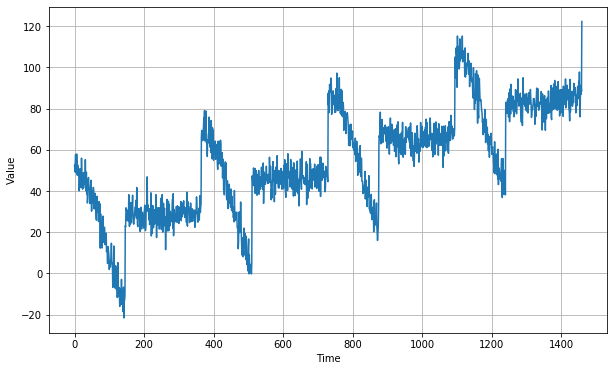

In [5]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,    # 1D CNN
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True), # two layers of LSTM
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(    # testing out learning rate
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 9s 1s/step - loss: 87.5326 - mae: 88.3356
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 87.2754 - mae: 87.6112
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 85.8511 - mae: 86.4322
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 84.3254 - mae: 84.8714
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 82.4993 - mae: 82.9793
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 80.0619 - mae: 80.7489
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 77.7010 - mae: 78.2492
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 75.0298 - mae: 75.6000
Epoch 9/100
8/8 [==============================] - 0s 23ms/step - loss: 72.5263 - mae: 72.9481
Epoch 10/100
8/8 [==============================] - 0s 23ms/step - loss: 69.8746 - mae: 70.4036
Epoch 11/100
8/8 [==============================] -

[1e-08, 0.0001, 0, 30]

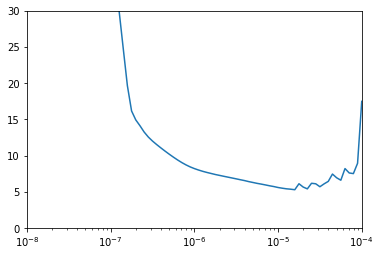

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,  # 1D CNN
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True), # two layers of LSTN
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)   # using the right learning rate
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 3s 327ms/step - loss: 57.2245 - mae: 58.2706 - val_loss: 24.8499 - val_mae: 25.2737
Epoch 2/500
8/8 [==============================] - 0s 30ms/step - loss: 23.6080 - mae: 24.3364 - val_loss: 35.8343 - val_mae: 36.9375
Epoch 3/500
8/8 [==============================] - 0s 35ms/step - loss: 16.6442 - mae: 17.2362 - val_loss: 37.3008 - val_mae: 37.5001
Epoch 4/500
8/8 [==============================] - 0s 33ms/step - loss: 13.8302 - mae: 14.3808 - val_loss: 22.6559 - val_mae: 23.4096
Epoch 5/500
8/8 [==============================] - 0s 35ms/step - loss: 10.8280 - mae: 11.3806 - val_loss: 19.1821 - val_mae: 19.7705
Epoch 6/500
8/8 [==============================] - 0s 36ms/step - loss: 9.0588 - mae: 9.5911 - val_loss: 16.4036 - val_mae: 16.9639
Epoch 7/500
8/8 [==============================] - 0s 38ms/step - loss: 7.9509 - mae: 8.4399 - val_loss: 16.3301 - val_mae: 16.9760
Epoch 8/500
8/8 [==============================] - 0s 38ms/step -

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

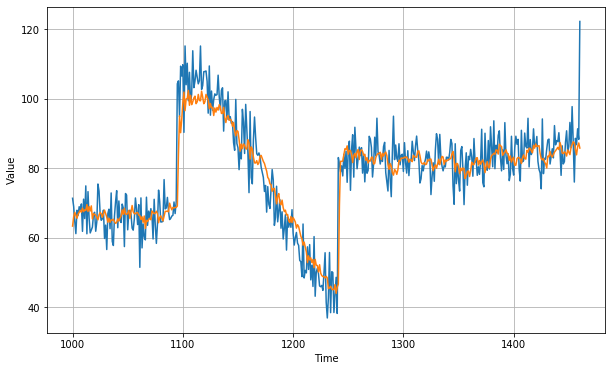

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.8746295

## Fully Convolutional Forecasting

WaveNet Architechture:

![](https://i.ytimg.com/vi/GyQnex_DK2k/maxresdefault.jpg)

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1])) 
for dilation_rate in (1, 2, 4, 8, 16, 32):      # adding 6 layers of CNN that has WaveNet like architechture
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))      # test learning rate
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 199ms/step - loss: 42.1698 - mae: 42.7348
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 41.7874 - mae: 42.3290
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 41.1948 - mae: 41.9344
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 40.7752 - mae: 41.5100
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 40.2081 - mae: 40.9796
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 40.2834 - mae: 40.2333
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 38.3743 - mae: 39.1041
Epoch 8/100
8/8 [==============================] - 0s 24ms/step - loss: 36.6141 - mae: 37.1632
Epoch 9/100
8/8 [==============================] - 0s 20ms/step - loss: 33.1234 - mae: 33.8623
Epoch 10/100
8/8 [==============================] - 0s 22ms/step - loss: 27.7717 - mae: 28.4692
Epoch 11/100
8/8 [==============================

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1)           3

[0.0001, 0.1, 0, 30]

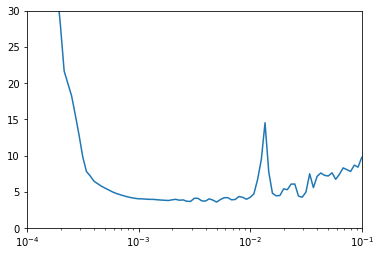

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1])) 
for dilation_rate in (1, 2, 4, 8, 16, 32):       # adding 6 layers of CNN that has WaveNet like architechture
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 218ms/step - loss: 40.0740 - mae: 40.6938 - val_loss: 72.6567 - val_mae: 73.4159
Epoch 2/500
8/8 [==============================] - 0s 36ms/step - loss: 37.9815 - mae: 38.6062 - val_loss: 68.0120 - val_mae: 68.4612
Epoch 3/500
8/8 [==============================] - 0s 35ms/step - loss: 34.7697 - mae: 35.5927 - val_loss: 60.6270 - val_mae: 61.3195
Epoch 4/500
8/8 [==============================] - 0s 39ms/step - loss: 30.4835 - mae: 31.3079 - val_loss: 50.3133 - val_mae: 50.6321
Epoch 5/500
8/8 [==============================] - 0s 36ms/step - loss: 24.6251 - mae: 25.4281 - val_loss: 36.3012 - val_mae: 37.1147
Epoch 6/500
8/8 [==============================] - 0s 36ms/step - loss: 20.2775 - mae: 20.6456 - val_loss: 31.7196 - val_mae: 32.5077
Epoch 7/500
8/8 [==============================] - 0s 38ms/step - loss: 18.7948 - mae: 19.3888 - val_loss: 29.5587 - val_mae: 30.5284
Epoch 8/500
8/8 [==============================] - 0s 39ms/st

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

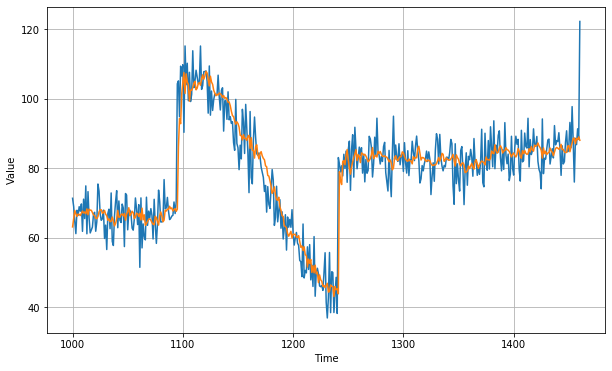

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [23]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.567415